In [326]:
import pandas as pd
import numpy as np
import datetime
import time
from matplotlib import pyplot


In [275]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

In [174]:
#read in the pre-processed training and test set from Dmitri's notebook
X_train = pd.read_csv("data/X_train_random_1592271085.csv")
Y_train = pd.read_csv("data/Y_train_random_1592271085.csv")
X_test = pd.read_csv("data/X_test_random_1592271085.csv")
Y_test = pd.read_csv("data/Y_test_random_1592271085.csv")

In [175]:
assert((X_train.shape[0] == Y_train.shape[0]) & (X_test.shape[0] == Y_test.shape[0]))

In [176]:
print(f'Dim of X_train: {X_train.shape}')
print(f'Dim of Y_train: {Y_train.shape}')
print("\n")
print(f'Dim of X_test: {X_test.shape}')
print(f'Dim of Y_test: {Y_test.shape}')

Dim of X_train: (1076080, 87)
Dim of Y_train: (1076080, 2)


Dim of X_test: (269020, 87)
Dim of Y_test: (269020, 2)


In [177]:
print(f'Train-test split: [{X_train.shape[0]/(X_train.shape[0] + X_test.shape[0])},\
{X_test.shape[0]/(X_train.shape[0] + X_test.shape[0])}]')

Train-test split: [0.8,0.2]


In [178]:
X_train.columns

Index(['id', 'application_type', 'grade', 'sub_grade', 'term',
       'initial_list_status', 'emp_length', 'verification_status', '_has_desc',
       'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'fico_range_low',
       'delinq_2yrs', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       '_credit_hist', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'addr_state_AL', 'addr_state_AR',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA',
       'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL',
       'addr_state_IN', 'addr_state_KS', 'addr_state_KY', 'addr_state_LA',
       'addr_state_M

In [184]:
X_train.head(2)

,id,application_type,grade,sub_grade,term,initial_list_status,emp_length,verification_status,_has_desc,loan_amnt,...,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,69863328,0,3,12,1,0,10,0,0,21200.0,...,0,0,0,0,0,0,0,0,0,0
1,65875191,0,3,14,0,0,9,2,0,6000.0,...,0,0,0,1,0,0,0,0,0,0


In [187]:
np.mean(Y_train.id == X_train.id)

1.0

In [188]:
np.mean(Y_test.id == X_test.id)

1.0

In [115]:
##we need to get fields needed for return calculations.
LC_df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")

/Users/rknatuahene/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [116]:
ret_df = LC_df[["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt", "recoveries"]].copy()

In [117]:
del LC_df ##free me some space


In [118]:
ret_df.term.value_counts(dropna=False)

 36 months    1609754
 60 months     650914
NaN                33
Name: term, dtype: int64

In [119]:
ret_df.dropna(subset=["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt"], inplace=True)

In [120]:
#convert term field to integer months
ret_df['term'] = ret_df['term'].apply(lambda t: np.int8(t.split()[0]))
ret_df.term.value_counts()


36    1607966
60     650275
Name: term, dtype: int64

In [121]:
ret_df[["total_pymnt", "funded_amnt", "recoveries"]].describe().T

,count,mean,std,min,25%,50%,75%,max
total_pymnt,2258241.0,12094.073850,9900.144164,10.0,4560.85,9343.69,16951.677553,63296.877917
funded_amnt,2258241.0,15041.772723,9186.916012,500.0,8000.00,12875.00,20000.000000,40000.000000
recoveries,2258241.0,142.565584,743.233625,0.0,0.00,0.00,0.000000,39859.550000


In [122]:
#convert issue_d and last_pymnt_d into datetime
ret_df['issue_d'] = ret_df['issue_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())
ret_df['last_pymnt_d'] = ret_df['last_pymnt_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())

In [123]:
#calculate the realized term of the loan in months. 
ret_df['realized_loan_term_mths'] = round((ret_df['last_pymnt_d'] - ret_df['issue_d'])/np.timedelta64(1, 'M'))

In [124]:
#where realized_loan_term_mths != term means default or pre-payment
np.sum(ret_df.realized_loan_term_mths != ret_df.term)/ret_df.shape[0]

0.9240351229120364

In [125]:
#remove rows where realized_loan_term_mths = 0
ret_df = ret_df[ret_df.realized_loan_term_mths > 0]

Function calc_return(....)

    calculate the effective(realized) annualized return on the funded amount of a loan
    assumption 1: monthly cash flow can be invested at a monthly rate of return rr
    This assumption allows us to simplify the return calculation to a sum of a geometric series
    with cash payments of: m, m(1+rr), m(1+rr)^2, m(1+rr)^3, ...,m(1+rr)^(last_pymnt_d -1) at the 
    end of months: 0,1,2,3,...last_pyment_d - 1 respectively
    The sequence of cash flows then forms a geometric series of the form
                                        a + ar + ar2 + ... + ar(n-1)
                                        which has a closed form sum:
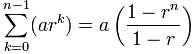

    where r = (1+rr) and a = m, the effective monthly installment payment over the actual life of the loan.
    
    assumption 2: when loan terminates early(due to default or pre-payment) total cash received
    + accrued interest are re-invested at the same rate rr from that time till the term of the loan

In [126]:
def calc_return(total_pymnt, term, funded_amnt, recoveries, realized_loan_term_mths, rr=0.01):
    effective_monthly_installments = (total_pymnt - recoveries)/realized_loan_term_mths
    
    #get total cash flow at loan termination as the geometric sum of effective monthly installments
    #yielding a constant rate of return rr.
    #This is from assumption #1
    total_cash_flow = effective_monthly_installments * ((1 - (1 + rr)**realized_loan_term_mths)) / (1 - (1 + rr))
    
    #add back recoveries to the get the lump sum at loan termination.
    total_cash_flow+= recoveries 

    #assumption #2. invest at rr till original term of loan.
    total_cash_flow = total_cash_flow * ((1 + rr)**(max(0,term - realized_loan_term_mths)))
    
    #calculate return and annualize
    return((12/term) * ((total_cash_flow - funded_amnt) / funded_amnt))


In [127]:
rr = 0.01
ret_df["annualized_returns"] = ret_df.apply(lambda row: calc_return(row[3], row[4], row[5], row[6], row[7], rr), axis =1)

In [128]:
ret_df.shape

(2249276, 9)

In [151]:
ret_df = ret_df.astype({'id': 'int64'})


In [161]:
ret_df.sample(10)

,id,issue_d,last_pymnt_d,total_pymnt,term,funded_amnt,recoveries,realized_loan_term_mths,annualized_returns
1403663,143978151,2018-11-01,2019-03-01,3116.700000,36,15000.0,0.0,4.0,-0.236667
735604,76234877,2016-04-01,2018-11-01,10953.861242,36,10000.0,0.0,31.0,0.113960
1126835,36129482,2014-11-01,2015-07-01,9381.950000,36,8800.0,0.0,8.0,0.152990
1669184,101921341,2017-03-01,2019-03-01,18271.270000,60,35000.0,0.0,24.0,-0.032110
2089327,123933527,2017-11-01,2019-03-01,9108.320000,60,21600.0,0.0,16.0,-0.059064
1799374,7284591,2013-10-01,2016-10-01,8962.054003,36,7800.0,0.0,36.0,0.124949
235221,53465013,2015-07-01,2016-12-01,21222.550979,36,20000.0,0.0,17.0,0.129942
2182264,94191432,2016-12-01,2019-03-01,2285.930000,36,2200.0,0.0,27.0,0.099074
662279,81476375,2016-06-01,2019-03-01,12131.090000,36,12000.0,0.0,33.0,0.075599
665107,81910323,2016-06-01,2019-03-01,3433.190000,36,3025.0,0.0,33.0,0.125764


In [322]:
def fit_return_models(X_train, Y_train, X_test, Y_test, model_name ="Ridge",
                      cv_parameters = {},
                      random_state = 1980):
    '''
    fits 2 return models using the sklearn model object implied by model name. One model for loans that defaulted and another for 
    loans that didn't default.
    code borrowed mostly from the danguetta.com paper/notebook.
    '''
    
    np.random.seed(random_state)
    
    #choose model based on user selection
    if model_name == "Lasso":
        model = linear_model.Lasso(normalize=True)
    elif model_name == "Ridge":
        model = linear_model.Ridge(normalize=True)
    elif model_name == "RandomF":
        model = RandomForestRegressor()

    
 
    #split data into defaulted series and non-defaulted series

    Y_train_bad = Y_train.loc[(Y_train._good == 0),['id', 'annualized_returns'] ]
    X_train_bad = X_train[X_train.id.isin(Y_train_bad.id)]
    Y_test_bad  = Y_test.loc[(Y_test._good == 0),['id', 'annualized_returns'] ]
    X_test_bad  = X_test[X_test.id.isin(Y_test_bad.id)]
    
    Y_train_good = Y_train.loc[(Y_train._good == 1),['id', 'annualized_returns'] ]
    X_train_good = X_train[X_train.id.isin(Y_train_good.id)]  
    Y_test_good  = Y_test.loc[(Y_test._good == 1),['id', 'annualized_returns'] ]
    X_test_good  = X_test[X_test.id.isin(Y_test_good.id)]

    
    ##remove ids for now to be added back afterwards
    train_bad_loan_ids = X_train_bad.pop('id')
    test_bad_loan_ids = pd.DataFrame(X_test_bad.pop('id'), columns=['id'])
#     print("missingness in bad loans df")
#     print(test_bad_loan_ids.isnull().sum(axis= 0))
#     print(test_bad_loan_ids.shape,"\n")

    train_good_loan_ids = X_train_good.pop('id')
    test_good_loan_ids = pd.DataFrame(X_test_good.pop('id'), columns=['id'])
    
#     print("missingness in good loans df")
#     print(test_good_loan_ids.isnull().sum(axis= 0))
#     print(test_good_loan_ids.shape,"\n")
    
    ##drop ids from Y datasets
    Y_train_good.drop('id', axis =1, inplace=True)
    Y_train_bad.drop('id', axis=1, inplace=True)
    
    Y_test_good.drop('id', axis =1, inplace=True)
    Y_test_bad.drop('id', axis =1, inplace=True)
    

    
    ##run model
    cv_model_bad = GridSearchCV(model, cv_parameters, scoring='r2')
    cv_model_good = GridSearchCV(model, cv_parameters, scoring='r2')

    #time and fit the models
    start_time = time.time()
    print("fitting model for defaulted loans")
    if model_name in ['RandomF', 'Logistic']:
        cv_model_bad.fit(X_train_bad, Y_train_bad.values.ravel())
    else:
        cv_model_bad.fit(X_train_bad, Y_train_bad)
        
    print("fitting model for non-defaulted loans")
    if model_name in ['RandomF', 'Logistic']:
        cv_model_good.fit(X_train_good, Y_train_good.values.ravel())
    else:
        cv_model_good.fit(X_train_good, Y_train_good)
        
    end_time = time.time()

    #pick best model from the fit for each regressor
    best_model_bad = cv_model_bad.best_estimator_
    best_model_good = cv_model_good.best_estimator_
            
    #tidy outputs    
    print("=========================")
    print("  Model: " + model_name )
    print("=========================")

    print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
    print("Optimal parameters:")
    print("model_default:",cv_model_bad.best_params_, "model_non-default",cv_model_good.best_params_)

    ##predicted returns - need to join back to get loan ids
    predicted_non_default_return = pd.DataFrame(best_model_good.predict(X_test_good), columns =['ret'])
    predicted_default_return     = pd.DataFrame(best_model_bad.predict(X_test_bad), columns =['ret'])
    
#     print("missingness in predicted bad loans df ")
#     print(predicted_default_return.isnull().sum(axis= 0))
#     print(predicted_default_return.shape,"\n")

#     print("missingness in predicted good loans df ")
#     print(predicted_non_default_return.isnull().sum(axis= 0))
#     print(predicted_non_default_return.shape,"\n")
    
    ## add ids back
    predicted_non_default_return = list(zip(test_good_loan_ids.id, predicted_non_default_return.ret))
    
    predicted_default_return = list(zip(test_bad_loan_ids.id, predicted_default_return.ret))
    
    print("")
    print("Testing r2 scores:")
    # Here we use different testing set to report the performance
    test_scores = {'model_default':r2_score(Y_test_bad,best_model_bad.predict(X_test_bad)),
                      'model_non_default':r2_score(Y_test_good,best_model_good.predict(X_test_good))}
 
    print("model_default:", test_scores['model_default'])
    print("model_non_default:", test_scores['model_non_default'])

    return { 'model_default':best_model_bad, 'model_non_default':best_model_good, 'predicted_non_default_return':predicted_non_default_return,
              'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

    
    


### Testing stuff


In [189]:
ret_df.head(2)

,id,issue_d,last_pymnt_d,total_pymnt,term,funded_amnt,recoveries,realized_loan_term_mths,annualized_returns
0,68407277,2015-12-01,2019-01-01,4421.723917,36,3600.0,0.0,37.0,0.159160
1,68355089,2015-12-01,2016-06-01,25679.660000,36,24700.0,0.0,6.0,0.145604


In [201]:
my_X_train = X_train.copy()
my_Y_train = Y_train.copy()

my_X_test = X_test.copy()
my_Y_test = Y_test.copy()

In [202]:
#merge returns data
my_Y_train = pd.merge(my_Y_train, ret_df[['id','annualized_returns']], how="left", on ='id')
my_Y_test = pd.merge(my_Y_test, ret_df[['id','annualized_returns']], how="left", on ='id')


In [204]:
my_Y_test.isnull().sum(axis=0)

id                       0
_good                    0
annualized_returns    2201
dtype: int64

In [205]:
my_Y_train.dropna(inplace=True)
my_Y_test.dropna(inplace=True)

array([1.00000000e-08, 1.23284674e-07, 1.51991108e-06, 1.87381742e-05,
       2.31012970e-04, 2.84803587e-03, 3.51119173e-02, 4.32876128e-01,
       5.33669923e+00, 6.57933225e+01, 8.11130831e+02, 1.00000000e+04])

## Test regression models


### Ridge

In [361]:
cv_parameters = {'alpha': np.logspace(-8, 1, num = 10), 'max_iter' : [1000]}

reg_ridge = fit_return_models(my_X_train, my_Y_train, my_X_test, my_Y_test, model_name ="Ridge",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: Ridge
Fit time: 87.47 seconds
Optimal parameters:
model_default: {'alpha': 0.0001, 'max_iter': 1000} model_non-default {'alpha': 1e-05, 'max_iter': 1000}

Testing r2 scores:
model_default: 0.12434522950733673
model_non_default: 0.7935675094758661


In [335]:
list_ids, returns_non_defaults = zip(*reg_ridge['predicted_non_default_return'])
list_ids, returns_defaults = zip(*reg_ridge['predicted_default_return'])

actual_defaults  = my_Y_test.loc[(my_Y_test._good == 0),['annualized_returns']]
actual_non_defaults = my_Y_test.loc[(my_Y_test._good == 1),['annualized_returns']]


In [359]:
print(f'actual_non_defaults:{np.mean(actual_non_defaults.annualized_returns):.4f}')
print(f'predicted_non_defaults:{np.mean(returns_non_defaults):.4f}')
print("\n")
print(f'actual_defaults:{np.mean(actual_defaults.annualized_returns):.4f}')
print(f'predicted_defaults:{np.mean(returns_defaults):.4f}')

actual_non_defaults:0.1609
predicted_non_defaults:0.1610


actual_defaults:-0.0688
predicted_defaults:-0.0692


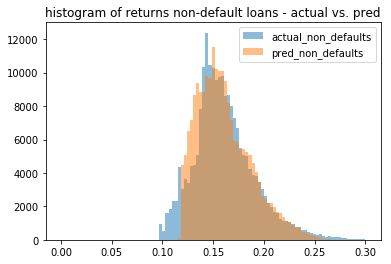

In [360]:
bins = np.linspace(-0., 0.3, 100)

pyplot.hist(actual_non_defaults.annualized_returns, bins, alpha=0.5, label='actual_non_defaults')

pyplot.hist(returns_non_defaults, bins, alpha=0.5, label='pred_non_defaults')

pyplot.legend(loc='upper right')
pyplot.title("histogram of returns non-default loans - actual vs. pred")
pyplot.show()

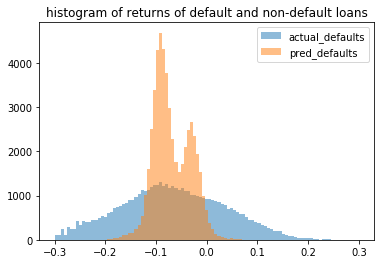

In [348]:
bins = np.linspace(-0.3, 0.3, 100)

pyplot.hist(actual_defaults.annualized_returns,  bins, alpha=0.5, label='actual_defaults')
pyplot.hist(returns_defaults,  bins, alpha=0.5, label='pred_defaults')
pyplot.legend(loc='upper right')
pyplot.title("histogram of returns of default and non-default loans")
pyplot.show()

In [365]:
np.sum(returns_non_defaults * actual_non_defaults.annualized_returns<0)

0

In [367]:
(np.sum(returns_defaults * actual_defaults.annualized_returns<0))/actual_defaults.shape[0]

0.26458489154824233

### Random Forest

In [279]:
cv_parameters = {'min_samples_leaf':[75],
                 'n_estimators': [35] }

reg_rf = fit_return_models(my_X_train, my_Y_train, my_X_test, my_Y_test, model_name ="RandomF",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: RandomF
Fit time: 2541.47 seconds
Optimal parameters:
model_default: {'min_samples_leaf': 75, 'n_estimators': 35} model_non-default {'min_samples_leaf': 75, 'n_estimators': 35}

Testing r2 scores:
model_default: 0.1823753694987873
model_non_default: 0.8331893337578045
